Example of running semantic segmentation on OCT data.  Note that we do not expect good results yet, in part due to a paucity of training data.  This will be corrected moving forward.

march 2016, mjp

In [3]:
%matplotlib inline

import os, sys, time
from socket import gethostname
import h5py

import numpy as np
import pylab as plt

np.random.seed(9999)

import keras
from keras import backend as K
from keras.models import load_model

sys.path.append('../..')
from cnn_tools import *
from data_tools import *


K.set_image_dim_ordering('th')

print('Using Keras version: %s' % keras.__version__)

Using Keras version: 1.1.1


(650, 512)


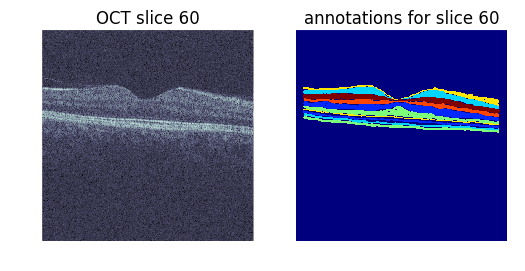

In [37]:
f = h5py.File('annotated.mat')
x_60 = f['x_60'].value.T
y_60 = f['y_60'].value.T
x_70 = f['x_70'].value.T
y_70 = f['y_70'].value.T

# crop so we have a square image whose dimension is a power of 2.
# The upper and lower y extremes aren't that interesting anyway
print(x_60.shape)
delta = int((x_60.shape[0]-512)/2)

x_60 = x_60[delta:-delta, :]
y_60 = y_60[delta:-delta, :]
x_70 = x_70[delta:-delta, :]
y_70 = y_70[delta:-delta, :]

# normalize
x_60 = x_60 / 255.
x_70 = x_70 / 255.

# show example data
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_60, interpolation='none', cmap='bone')
plt.axis('off')
plt.title('OCT slice 60')

plt.subplot(1,2,2)
plt.imshow(y_60, interpolation='none', cmap='jet')
plt.axis('off')
plt.title('annotations for slice 60')
plt.show()

In [29]:
# TODO: get more representative weights; currently this is a kind of dubious transfer learning experiment
#       (which is not expected to work well at all)
weights_file = '../ISBI_2012/weights_epoch0011.hdf5'

# load model
model = create_unet((1, x_60.shape[0], x_60.shape[1]))
model.load_weights(weights_file)

In [32]:
# deploy
X_test = np.copy(x_60)
X_test = X_test[np.newaxis, np.newaxis, ...]
print(X_test.shape)

tic = time.time()
Y_hat = deploy_model(X_test, model)
print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))

(1, 1, 512, 512)
[info]: total time to deploy on system "pekalmj1-ml2": 5.43 sec


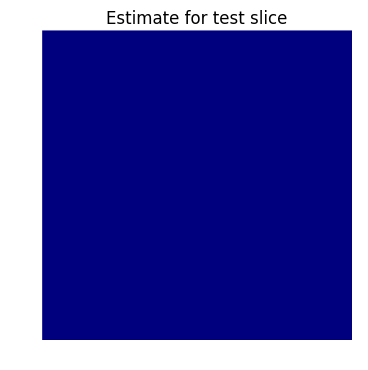

In [34]:
# visualize result
plt.figure()
plt.imshow(Y_hat[0,0,...], interpolation='none', cmap='jet')
plt.axis('off')
plt.title('Estimate for test slice')
plt.show()